In [10]:
import torch
import math

from torch import optim
from torch import Tensor
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F
import dlc_practical_prologue      
size=1000;
train_input, train_target, train_classes, test_input, test_target, test_classes = \
    dlc_practical_prologue.generate_pair_sets(size)
train_input, train_target, train_classes = Variable(train_input), Variable(train_target), Variable((train_classes))
test_input, test_target, test_classes = Variable(test_input), Variable(test_target), Variable(test_classes)
mini_batch_size = 10


C:\Users\antho\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\antho\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\antho\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\antho\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


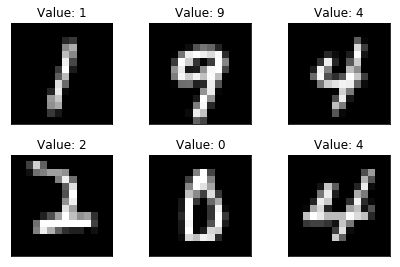

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(test_input[i][0], cmap='gray', interpolation='none')
  plt.title("Value: {}".format(test_classes[i][0]))  
  plt.tight_layout()
  plt.xticks([])
  plt.yticks([])

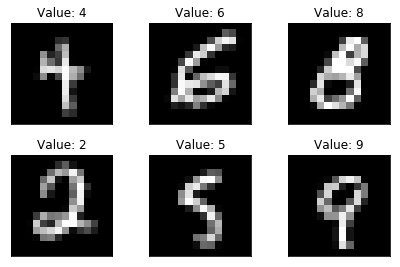

In [12]:
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(test_input[i][1], cmap='gray', interpolation='none')
  plt.title("Value: {}".format(test_classes[i][1]))  
  plt.tight_layout()
  plt.xticks([])
  plt.yticks([])

# First neural net
Train the model on all the 2000 images in train_input

In [13]:
my_train_input = train_input.reshape([2000,14,14])
my_train_classes = train_classes.reshape([2000])
my_test_input = test_input.reshape([2000,14,14])
my_test_classes = test_classes.reshape([2000])

In [14]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# number of epoch
num_epochs = 25
# batch size to compute mini-batch
batch_size = 2
# number of pixels in the image 
input_size = 196
# number of possible digit: 0 to 9 
num_class = 10
# small step to find a minima
learning_rate = 0.001
# hidden size
hidden_size = 1000

In [15]:
def test_accuracy(model_, my_test_input_, my_test_classes_, batch_size_):
    total = 0
    well_predicted_count = 0
    for i in range(int(len(my_test_input_)/batch_size_)):
        images = my_test_input_.narrow(0,i*batch_size_,batch_size_).to(device)
        labels = my_test_classes_.narrow(0,i*batch_size_,batch_size_).to(device)
        total += labels.size(0)

        outputs = model_(images, batch_size_)
        _, predictions = torch.max(outputs.data, 1)

        well_predicted_count += (predictions == labels).sum().item()

    return 1 - well_predicted_count / total

In [16]:
import datetime
import time

def train_model(model_, my_train_input_, my_train_classes_, criterion_, optimizer_,num_epochs_,batch_size_):

    train_error = []
    test_error = []
    # train function
    for epoch in range(1, num_epochs_+1):
        for i in range(int(len(my_train_input_)/batch_size_)):  
            #print(str(i) + ": 1:" + str(datetime.datetime.utcnow()))
            # Move tensors to the configured device
            images = my_train_input_.narrow(0,i*batch_size_,batch_size_).to(device)
            labels = my_train_classes_.narrow(0,i*batch_size_,batch_size_).to(device)
            #print(str(i) + ": 2: " + str(datetime.datetime.utcnow()))

            # Forward pass
            outputs = model_(images, batch_size_)
            #print(str(i) + ": 3: " + str(datetime.datetime.utcnow()))
            loss = criterion_(outputs, labels)
            #print(str(i) + ": 4: " + str(datetime.datetime.utcnow()))

            # Backward and optimize
            optimizer_.zero_grad()
            loss.backward()
            optimizer_.step()            
            #print(str(i) + ": 5: " + str(datetime.datetime.utcnow()))


        train_error.append(test_accuracy(model_, my_train_input_, my_train_classes_,batch_size_))
        test_error.append(test_accuracy(model_, my_test_input, my_test_classes,batch_size_))
        if(epoch % 5 == 0 or epoch == 1):    
            print ('Loss: {:.4f} on epoch: {}'.format(loss.item(),epoch))
    return train_error, test_error

In [17]:
#as we got 100% on the train error it seems that we just leared by heart the train dataset
# let's adding regularization:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_class):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3))
        self.drop_out = nn.Dropout(0.2)
        self.fc1 = nn.Linear(64, 25)
        self.fc2 = nn.Linear(25, 10)
    
    def forward(self, x, batch_size_images):
        x = x.reshape(batch_size_images,1,14,14)
        out = self.layer1(x)        
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
# creating neural net
model = NeuralNet(input_size, hidden_size, num_class).to(device)

# CrossEntropyLoss and optimizer which minimize loss with learning rate step
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 

train_error, test_error = train_model(model, my_train_input, my_train_classes, criterion, optimizer, num_epochs, batch_size)

Loss: 1.1874 on epoch: 1
Loss: 0.0006 on epoch: 5
Loss: 0.2135 on epoch: 10
Loss: 0.0000 on epoch: 15
Loss: 0.0000 on epoch: 20
Loss: 0.0000 on epoch: 25


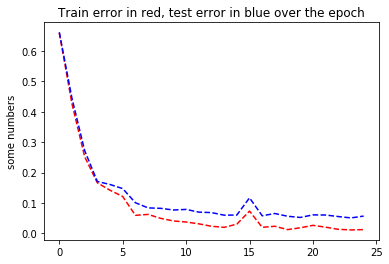

In [18]:
plt.plot(train_error, 'r--', test_error, 'b--')
plt.ylabel('some numbers')
plt.title("Train error in red, test error in blue over the epoch")
plt.show()

In [19]:
train_error

[0.6595,
 0.4265,
 0.25249999999999995,
 0.16649999999999998,
 0.14200000000000002,
 0.12150000000000005,
 0.0595,
 0.0625,
 0.04949999999999999,
 0.041000000000000036,
 0.03749999999999998,
 0.03149999999999997,
 0.023499999999999965,
 0.020000000000000018,
 0.03049999999999997,
 0.07350000000000001,
 0.020000000000000018,
 0.023499999999999965,
 0.012499999999999956,
 0.01849999999999996,
 0.026499999999999968,
 0.020499999999999963,
 0.013499999999999956,
 0.011499999999999955,
 0.012499999999999956]

In [20]:
test_error

[0.6619999999999999,
 0.4445,
 0.27249999999999996,
 0.17100000000000004,
 0.16100000000000003,
 0.14749999999999996,
 0.10099999999999998,
 0.08399999999999996,
 0.08250000000000002,
 0.07699999999999996,
 0.07899999999999996,
 0.06999999999999995,
 0.0685,
 0.06000000000000005,
 0.0605,
 0.11699999999999999,
 0.05800000000000005,
 0.0655,
 0.056499999999999995,
 0.05249999999999999,
 0.061000000000000054,
 0.0605,
 0.055499999999999994,
 0.051000000000000045,
 0.05700000000000005]

# Testing on the 2 batches
A model for the two batch of 1000 images

In [21]:
my_test_input1 = test_input[:,0,:]
my_test_input2 = test_input[:,1,:]
my_test_classes1 = test_classes[0:1000,0]
my_test_classes2 = test_classes[0:1000,1]

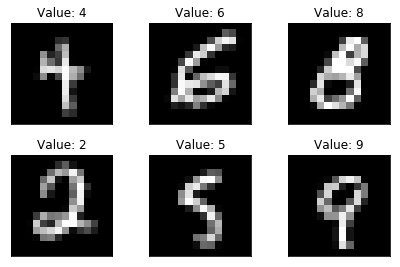

In [22]:
# verifying the digits and labels
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(my_test_input2[i], cmap='gray', interpolation='none')
  plt.title("Value: {}".format(my_test_classes2[i]))  
  plt.tight_layout()
  plt.xticks([])
  plt.yticks([])

In [28]:
print("Error on batch 1: {}".format(test_accuracy(model, my_test_input1, my_test_classes1,batch_size)))
print("Error on batch 2: {}".format(test_accuracy(model, my_test_input2, my_test_classes2,batch_size)))

Error on batch 1: 0.062000000000000055
Error on batch 2: 0.051000000000000045


# Building neural net for Digit Comparison

In [24]:
# number of epoch
num_epochs_dc = num_epochs
# batch size to compute mini-batch
batch_size_dc = batch_size
# number of pixels in the image 
input_size_dc = 2
# number of possible digit: 0 to 9 
num_class_dc = 1
# small step to find a minima
learning_rate_dc = 0.003
# hidden size
hidden_size_dc = 200

# Fully connected neural network with one hidden layer
class NeuralNet_dc(nn.Module):
    def __init__(self, input_size, hidden_size, num_class):
        super(NeuralNet_dc, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, hidden_size)  
        self.layer3 = nn.Linear(hidden_size, num_class)  
    
    def forward(self, x):
        outputs = self.layer1(x)
        outputs = self.relu(outputs)
        outputs = self.layer3(outputs)
        return outputs.reshape([1,batch_size_dc])[0]
        
    
# creating neural net
model_dc = NeuralNet_dc(input_size_dc, hidden_size_dc, num_class_dc).to(device)

# MSELoss and optimizer which minimize loss with learning rate step
criterion_dc = nn.MSELoss()
optimizer_dc = torch.optim.SGD(model_dc.parameters(), lr=learning_rate_dc)  

# train function
for epoch in range(1, num_epochs_dc+1):
    for i in range(int(len(train_classes)/batch_size_dc)):  
        # Move tensors to the configured device
        inputs = train_classes.narrow(0,i*batch_size_dc,batch_size_dc).to(device).float()
        labels = train_target.narrow(0,i*batch_size_dc,batch_size_dc).to(device)

        # Forward pass
        outputs = model_dc(inputs)
        loss = criterion_dc(outputs, labels.float())
        
        # Backward and optimize
        optimizer_dc.zero_grad()
        loss.backward()
        optimizer_dc.step()
    if(epoch % 5 == 0):    
        print ('Loss: {:.4f} on epoch: {}'.format(loss.item(),epoch))

Loss: 0.0052 on epoch: 5
Loss: 0.0028 on epoch: 10
Loss: 0.0024 on epoch: 15
Loss: 0.0022 on epoch: 20
Loss: 0.0022 on epoch: 25


In [25]:
# test function
def test_accuracy_dc(model_, my_test_input_, my_test_classes_):
    total = 0
    well_predicted_count = 0
    for i in range(int(len(my_test_input_)/batch_size_dc)):

        inputs = my_test_input_.narrow(0,i*batch_size_dc,batch_size_dc).to(device)
        labels = my_test_classes_.narrow(0,i*batch_size_dc,batch_size_dc).to(device)
        total += labels.size(0)
        
        outputs = model_(inputs.float())
        t = Variable(torch.Tensor([0.5]))
        predictions = (outputs > t).float() * 1

        well_predicted_count += (predictions == labels.float()).sum().item()
    print('Accuracy: {} %'.format(100 * well_predicted_count / total))

test_accuracy_dc(model_dc, test_classes, test_target)


Accuracy: 100.0 %


# Running both neural networks in sequence

In [31]:
# test function
def getting_y(model_, my_test_input_, my_test_classes_,batch_size_):
    total = 0
    well_predicted_count = 0
    y = torch.Tensor()
    for i in range(int(len(my_test_input_)/batch_size)):

        images = my_test_input_.narrow(0,i*batch_size,batch_size).to(device)
        labels = my_test_classes_.narrow(0,i*batch_size,batch_size).to(device)
        total += labels.size(0)

        outputs = model_(images,batch_size_)
        _, predictions = torch.max(outputs.data, 1)
        #y += predictions
        well_predicted_count += (predictions == labels).sum().item()

    print('Accuracy: {} %'.format(100 * well_predicted_count / total))
    y_ = model_(my_test_input_,1000)
    _, predictions_ = torch.max(y_.data, 1)
    return predictions_

y1 = getting_y(model, my_test_input1, my_test_classes1,batch_size)
y2 = getting_y(model, my_test_input2, my_test_classes2,batch_size)
y_test_classes = torch.tensor([y1.tolist(), y2.tolist()]).transpose_(0, 1)
y_test_classes

Accuracy: 94.9 %
Accuracy: 94.8 %


tensor([[1, 4],
        [9, 6],
        [4, 8],
        ...,
        [5, 4],
        [2, 9],
        [3, 2]])

In [32]:
# test function
def digit_comparison(model_, my_test_input_, my_test_classes_):
    total = 0
    well_predicted_count = 0
    for i in range(int(len(my_test_input_)/batch_size_dc)):

        inputs = my_test_input_.narrow(0,i*batch_size_dc,batch_size_dc).to(device)
        labels = my_test_classes_.narrow(0,i*batch_size_dc,batch_size_dc).to(device)
        total += labels.size(0)
        
        outputs = model_(inputs.float())
        t = Variable(torch.Tensor([0.5]))
        predictions = (outputs > t).float() * 1

        well_predicted_count += (predictions == labels.float()).sum().item()
    print('Accuracy: {} %'.format(100 * well_predicted_count / total))

test_accuracy_dc(model_dc, y_test_classes, test_target)

Accuracy: 95.9 %
